# Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import util
import pickle 
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import time

In [2]:
import importlib
importlib.reload(util)

<module 'util' from '/Users/ellajones/util.py'>

In [3]:
qqq_df = pd.read_csv("qqq_df.csv")

feature_eng_df = util.create_snapshot_features(qqq_df)

folder_path = "/Users/ellajones/Downloads/Optiver_additional data"

time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)

time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

qqq_df_1 = pd.merge(
    feature_eng_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

feature_cols = ['wap', 'spread_pct', 'imbalance', 'depth_ratio', 'log_return']
qqq_df_ts = util.generate_tick_sequences(qqq_df_1, feature_cols)
qqq_df_ts.to_pickle('qqq_df_ts.pkl')

In [5]:
qqq_df_ts = pd.read_pickle('qqq_df_ts.pkl') #data with tick sequences. 

# BASELINE

## Loading Model

In [60]:
start_time_4 = time.time()

In [61]:
start_time_1 = time.time()

os.chdir('/Users/ellajones/Downloads/Model/')

lstm_bl = load_model('lstm_baseline.h5',compile=False)

with open('lstm_baseline_scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

end_time_1 = time.time()

## Scaling 

In [62]:
start_time_2 = time.time()

total = len(qqq_df_ts)
subset = qqq_df_ts.iloc[-total // 5:]

X = np.stack(subset['X'].values)  
y = subset['y'].values  

scaler_x = scalers['x_scaler']

samples, steps, feats = X.shape
X_scaled = np.empty_like(X)

for i in range(samples):
    X_scaled[i] = scaler_x.transform(X[i])
    if i % 50000 == 0:
        print(f"X Scaled {i}/{samples} sequences")

        
scaler_y = scalers['y_scaler']

samples = len(y)
y_scaled = np.empty((samples,))

for i in range(samples):
    y_scaled[i] = scaler_y.transform([[y[i]]])[0, 0]  
    if i % 50000 == 0:
        print(f"Y Scaled {i}/{samples} targets")

end_time_2 = time.time()

X Scaled 0/151060 sequences
X Scaled 50000/151060 sequences
X Scaled 100000/151060 sequences
X Scaled 150000/151060 sequences
Y Scaled 0/151060 targets
Y Scaled 50000/151060 targets
Y Scaled 100000/151060 targets
Y Scaled 150000/151060 targets


## Model

In [63]:
start_time_3 = time.time()

y_pred_scale = lstm_bl.predict(X_scaled, batch_size=512).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scale.reshape(-1, 1)).flatten()

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time':subset['start_time'].values,
    'y_true': subset['y'].values,
    'y_pred': y_pred
})

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
qlike = util.qlike_loss(y,y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"QLIKE: {qlike:.6f}")

end_time_3 = time.time()

296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step
MSE: 0.000000
RMSE: 0.000051
QLIKE: 0.298656


## Evaluation

In [64]:
util.directional_accuracy(y,y_pred)

0.3383777199637228

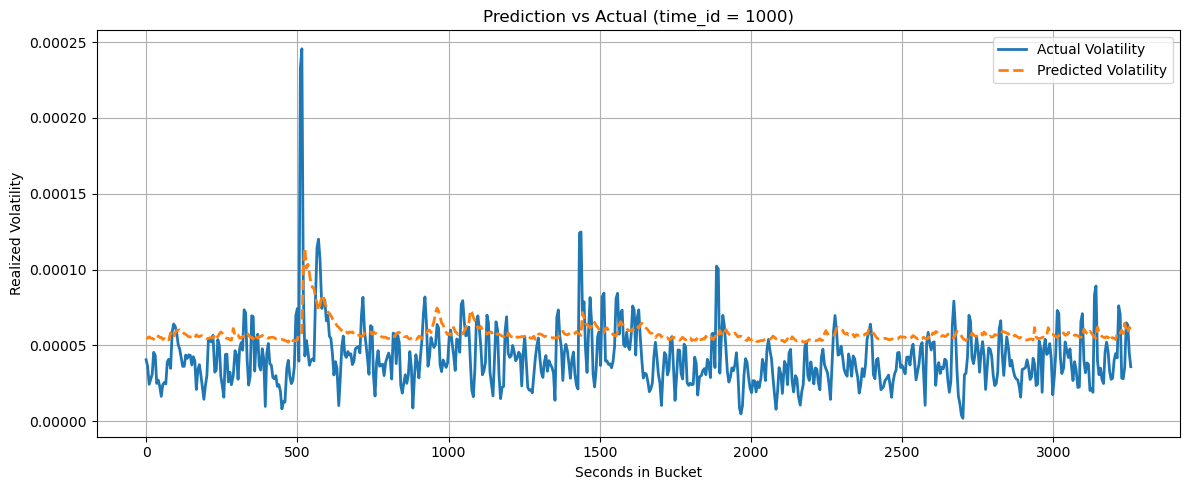

In [65]:
util.plot_prediction_vs_actual(results_df, 1000, y_true_col='y_true', y_pred_col='y_pred')

Mean Residual: 0.000002
Std of Residual: 0.000050
Min Residual: -0.000270
Max Residual: 0.001038


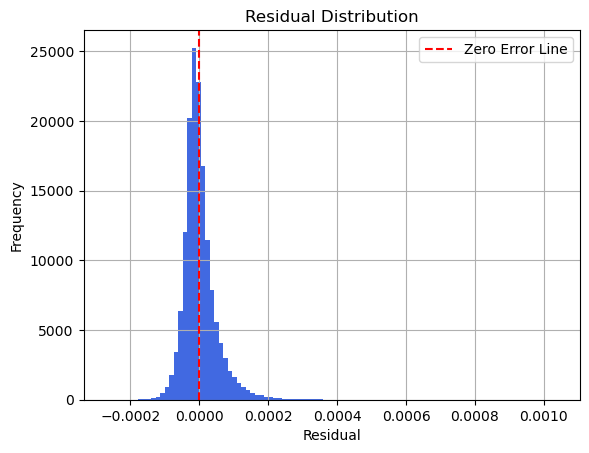

In [66]:
residuals = y - y_pred

print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std of Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")


plt.hist(residuals, bins=100, color='royalblue')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid()
plt.show()

## Time

In [68]:
end_time_4 = time.time()

print('Computation Times:')
print(f"Loading Model: {end_time_1 - start_time_1:.2f} seconds")
print(f"Scaling: {end_time_2 - start_time_2:.2f} seconds")
print(f"Model Run Time: {end_time_3 - start_time_3:.2f} seconds")
print(f"Total Computation Time: {end_time_4 - start_time_4:.2f} seconds")

Model and Feature Loading Phase time: 0.05 seconds
Feature Engineering: 17.93 seconds
Model Run Time: 36.84 seconds
Total computation time: 116.11 seconds


# Tuned Model

## Loading Model

In [58]:
start_time_4 = time.time()

In [59]:
start_time_1 = time.time()

os.chdir('/Users/ellajones/Downloads/Model/')

lstm_v2 = load_model('config_v256d03.h5',compile=False)

with open('config_v256d03_scalers.pkl', 'rb') as f:
    scalers_v2 = pickle.load(f)

end_time_1 = time.time()

/Users/ellajones/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Scaling

In [69]:
start_time_2 = time.time()

total = len(qqq_df_ts)
subset = qqq_df_ts.iloc[-total // 5:]

X = np.stack(subset['X'].values)  
y = subset['y'].values  

scaler_x_v2 = scalers_v2['x_scaler']

samples, steps, feats = X.shape
X_scaled = np.empty_like(X)

for i in range(samples):
    X_scaled[i] = scaler_x_v2.transform(X[i])
    if i % 50000 == 0:
        print(f"X Scaled {i}/{samples} sequences")

        
scaler_y_v2 = scalers_v2['y_scaler']

samples = len(y)
y_scaled = np.empty((samples,))

for i in range(samples):
    y_scaled[i] = scaler_y_v2.transform([[y[i]]])[0, 0]  
    if i % 50000 == 0:
        print(f"Y Scaled {i}/{samples} targets")

end_time_2 = time.time()

X Scaled 0/151060 sequences
X Scaled 50000/151060 sequences
X Scaled 100000/151060 sequences
X Scaled 150000/151060 sequences
Y Scaled 0/151060 targets
Y Scaled 50000/151060 targets
Y Scaled 100000/151060 targets
Y Scaled 150000/151060 targets


## Model

In [70]:
start_time_3 = time.time()

y_pred_scale = lstm_v2.predict(X_scaled, batch_size=512).flatten()
y_pred = scaler_y_v2.inverse_transform(y_pred_scale.reshape(-1, 1)).flatten()

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time':subset['start_time'].values,
    'y_true': subset['y'].values,
    'y_pred': y_pred
})

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
qlike = util.qlike_loss(y,y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"QLIKE: {qlike:.6f}")

end_time_3 = time.time()

296/296 ━━━━━━━━━━━━━━━━━━━━ 144s 486ms/step
MSE: 0.000000
RMSE: 0.000051
QLIKE: 0.289931


## Evaluation

In [71]:
util.directional_accuracy(y,y_pred)

0.3848827279407384

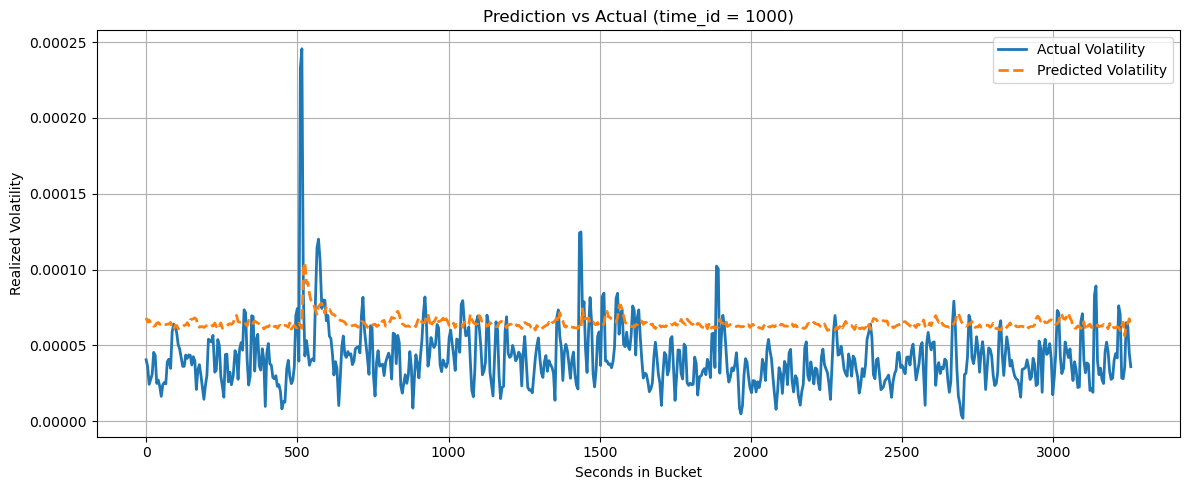

In [72]:
util.plot_prediction_vs_actual(results_df, 1000, y_true_col='y_true', y_pred_col='y_pred')

Mean Residual: -0.000009
Std of Residual: 0.000050
Min Residual: -0.000312
Max Residual: 0.001013


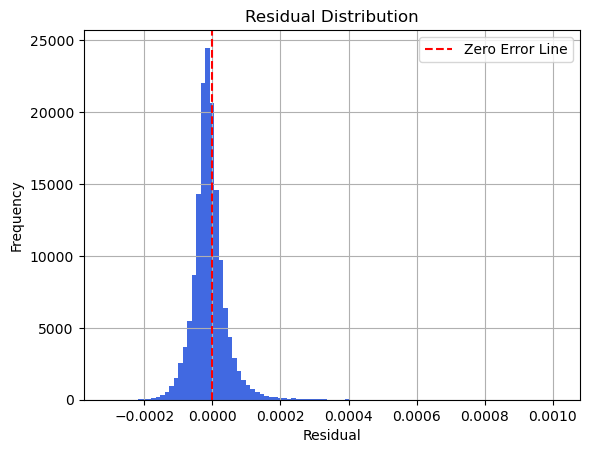

In [73]:
residuals = y - y_pred

print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std of Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")


plt.hist(residuals, bins=100, color='royalblue')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid()
plt.show()

## Time

In [76]:
end_time_4 = time.time()

print('Computation Times:')

print(f"Loading Model: {end_time_1 - start_time_1:.2f} seconds")
print(f"Scaling: {end_time_2 - start_time_2:.2f} seconds")
print(f"Model Run Time: {end_time_3 - start_time_3:.2f} seconds")
print(f"Total Computation Time: {end_time_4 - start_time_4:.2f} seconds")

Computation Times:
Loading Model: 0.05 seconds
Scaling: 16.85 seconds
Model Run Time: 149.04 seconds
Total Computation Time: 443.65 seconds


# Adding Features

## Loading Model

In [3]:
start_time_4 = time.time()

In [4]:
start_time_1 = time.time()

os.chdir('/Users/ellajones/Downloads/Model/')

lstm_mf = load_model('config_v256d03_more_feature.h5',compile=False)

with open('config_v256d03_more_feature_scalers.pkl', 'rb') as f:
    scalers_mf = pickle.load(f)

end_time_1 = time.time()

/Users/ellajones/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Feature Engineering + Scaling

In [5]:
start_time_2 = time.time()

In [6]:
qqq_df_1 = pd.read_csv("qqq_df_1.csv")
qqq_df_1.head()

,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return,datetime
0,104919,6,1800.0,313.80,313.83,313.79,313.84,1700,802,200,800,313.815,313.820384,0.03,0.000096,0.358913,2.119701,0.000000,NaN
1,104919,6,1800.0,313.80,313.83,313.79,313.84,1700,802,200,800,313.815,313.820384,0.03,0.000096,0.358913,2.119701,0.000000,NaN
2,104919,6,1801.0,313.85,313.87,313.84,313.88,200,100,1000,1225,313.860,313.863332,0.02,0.000064,0.333333,2.000000,0.000137,NaN
3,104919,6,1801.0,313.85,313.87,313.84,313.88,200,100,1000,1225,313.860,313.863332,0.02,0.000064,0.333333,2.000000,0.000000,NaN
4,104919,6,1802.0,313.82,313.85,313.81,313.86,1100,200,800,1000,313.835,313.845384,0.03,0.000096,0.692308,5.500000,-0.000057,NaN


In [7]:
qqq_df_mf = util.add_features(qqq_df_1)

In [93]:
qqq_df_mf.columns

Index(['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2', 'mid_price', 'wap', 'bid_ask_spread', 'spread_pct',
       'imbalance', 'depth_ratio', 'log_return', 'datetime', 'log_wap_change',
       'rolling_std_logret', 'spread_zscore', 'volume_imbalance'],
      dtype='object')

In [8]:
feature_cols_mf = ['wap', 'spread_pct', 'imbalance', 'depth_ratio', 'log_return','log_wap_change','rolling_std_logret', 'spread_zscore', 'volume_imbalance']
qqq_df_mf_ts = util.generate_tick_sequences(qqq_df_mf, feature_cols_mf)
                        
##qqq_df_ts.to_pickle('qqq_df_ts.pkl') 

In [9]:
total = len(qqq_df_mf_ts)
subset = qqq_df_mf_ts.iloc[-total // 5:]

X = np.stack(subset['X'].values)  
y = subset['y'].values  

scaler_x_mf = scalers_mf['x_scaler']

samples, steps, feats = X.shape
X_scaled = np.empty_like(X)

for i in range(samples):
    X_scaled[i] = scaler_x_mf.transform(X[i])
    if i % 50000 == 0:
        print(f"X Scaled {i}/{samples} sequences")

        
scaler_y_mf = scalers_mf['y_scaler']

samples = len(y)
y_scaled = np.empty((samples,))

for i in range(samples):
    y_scaled[i] = scaler_y_mf.transform([[y[i]]])[0, 0]  
    if i % 50000 == 0:
        print(f"Y Scaled {i}/{samples} targets")

end_time_2 = time.time()

X Scaled 0/151060 sequences
X Scaled 50000/151060 sequences
X Scaled 100000/151060 sequences
X Scaled 150000/151060 sequences
Y Scaled 0/151060 targets
Y Scaled 50000/151060 targets
Y Scaled 100000/151060 targets
Y Scaled 150000/151060 targets


## Model

In [10]:
start_time_3 = time.time()

y_pred_scale = lstm_mf.predict(X_scaled, batch_size=512).flatten()
y_pred = scaler_y_mf.inverse_transform(y_pred_scale.reshape(-1, 1)).flatten()

results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time':subset['start_time'].values,
    'y_true': subset['y'].values,
    'y_pred': y_pred
})

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
qlike = util.qlike_loss(y,y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"QLIKE: {qlike:.6f}")

end_time_3 = time.time()

296/296 ━━━━━━━━━━━━━━━━━━━━ 146s 494ms/step
MSE: 0.000000
RMSE: 0.000051
QLIKE: 0.281800


## Evaluation

In [11]:
util.directional_accuracy(y,y_pred)

0.36576437021296315

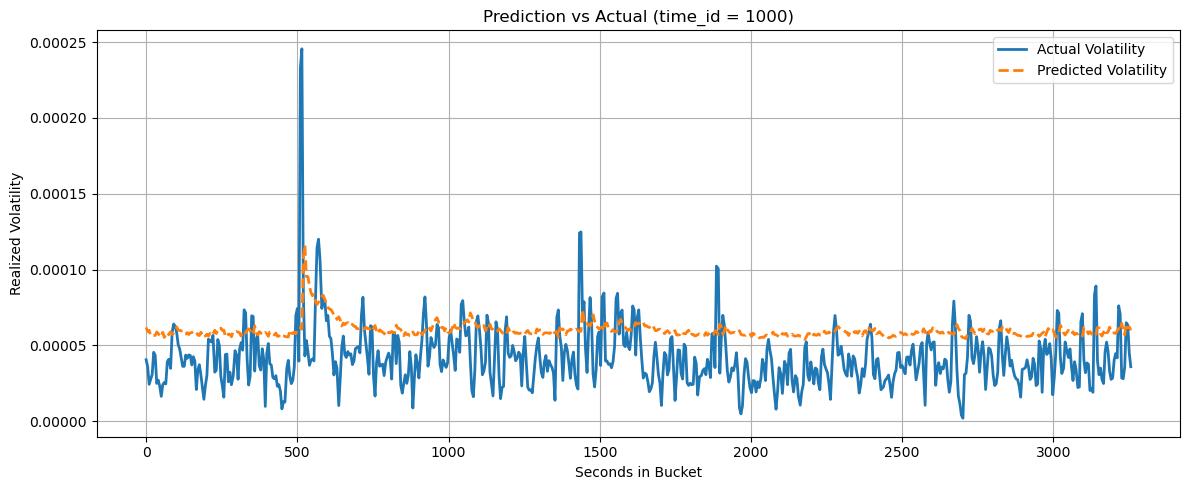

In [12]:
util.plot_prediction_vs_actual(results_df, 1000, y_true_col='y_true', y_pred_col='y_pred')

Mean Residual: -0.000008
Std of Residual: 0.000050
Min Residual: -0.000322
Max Residual: 0.001018


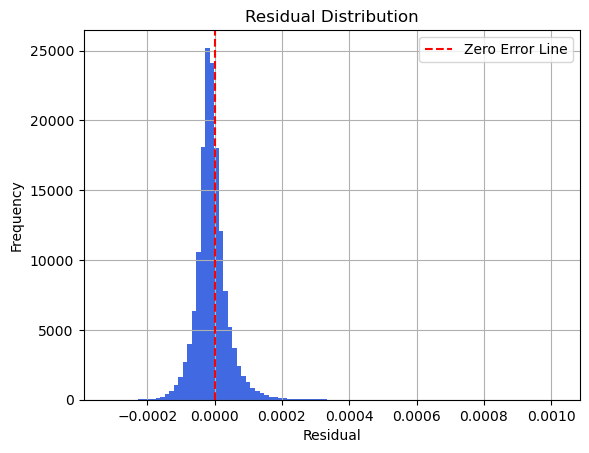

In [13]:
residuals = y - y_pred

print(f"Mean Residual: {np.mean(residuals):.6f}")
print(f"Std of Residual: {np.std(residuals):.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")


plt.hist(residuals, bins=100, color='royalblue')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid()
plt.show()

## Time

In [15]:
end_time_4 = time.time()

print('Computation Times:')

print(f"Loading Model: {end_time_1 - start_time_1:.2f} seconds")
print(f"Scaling + Feature Engineering: {end_time_2 - start_time_2:.2f} seconds")
print(f"Model Run Time: {end_time_3 - start_time_3:.2f} seconds")
print(f"Total Computation Time: {end_time_4 - start_time_4:.2f} seconds")

Computation Times:
Loading Model: 0.08 seconds
Scaling + Feature Engineering: 245.21 seconds
Model Run Time: 183.10 seconds
Total Computation Time: 678.71 seconds
